In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
from torch.utils.data.dataset import random_split

## Dataset Definition

In [26]:
class FacialFeaturesDataset(Dataset):
    def __init__(self, hdf5_path):
        self.hdf5_path = hdf5_path
        self.hdf5_file = None
        self.keys = []

        with h5py.File(self.hdf5_path, 'r') as file:
            self.keys = list(file.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_path, 'r')

        group_key = self.keys[idx]
        group = self.hdf5_file[group_key]

        features = np.array(group['feature'])
        label = group.attrs['label']

        return torch.tensor(features, dtype=torch.float), torch.tensor(label, dtype=torch.long)

    def close(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()


## Model Definition

In [27]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return out

In [28]:
def validate(model, data_loader, criterion, device):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad(): 
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy


## Execution

In [29]:
############################################
# Params
num_epochs = 50
learning_rate = 0.0001
hidden_size = 4096

train_ratio = 0.8
val_ratio = 0.1
# Test ratio is the rest
patience = 10
batch_size = 64


# Speed Params
num_workers = 0

############################################

# Model instantiation
model = SimpleClassifier(input_size=2048, hidden_size=hidden_size, num_classes=3)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.1, verbose=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataset = FacialFeaturesDataset('facial_features-CMU_MOSEI_120_averaged.h5')

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict()) 

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        # print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model ...")
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        # Save model (optional)
        torch.save(model.state_dict(), 'best_model_averaged_120.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/50], Training Loss: 0.9798, Validation Loss: 0.9656, Validation Accuracy: 0.5568
Epoch [2/50], Training Loss: 0.9288, Validation Loss: 0.9417, Validation Accuracy: 0.5895
Epoch [3/50], Training Loss: 0.8961, Validation Loss: 0.9473, Validation Accuracy: 0.5798
Epoch [4/50], Training Loss: 0.8631, Validation Loss: 0.9652, Validation Accuracy: 0.5738
Epoch [5/50], Training Loss: 0.8312, Validation Loss: 0.9624, Validation Accuracy: 0.5846
Epoch [6/50], Training Loss: 0.7947, Validation Loss: 0.9377, Validation Accuracy: 0.5992
Epoch [7/50], Training Loss: 0.7648, Validation Loss: 0.9369, Validation Accuracy: 0.5961
Epoch [8/50], Training Loss: 0.7271, Validation Loss: 0.9562, Validation Accuracy: 0.6034
Epoch [9/50], Training Loss: 0.7051, Validation Loss: 0.9403, Validation Accuracy: 0.6028
Epoch [10/50], Training Loss: 0.6630, Validation Loss: 0.9568, Validation Accuracy: 0.6058
Epoch [11/50], Training Loss: 0.6332, Validation Loss: 0.9750, Validation Accuracy: 0.5937
Epoch [1

## Plotting training vs validation losses

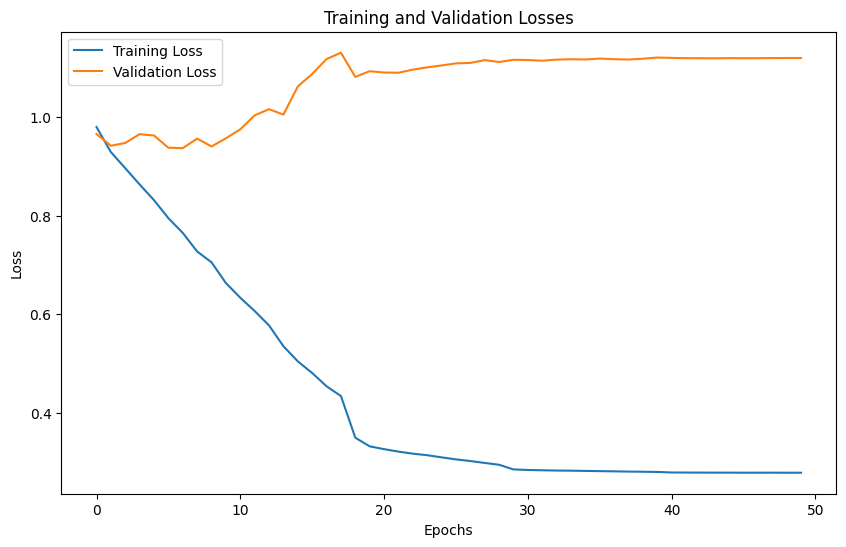

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Testing model

In [32]:
model.load_state_dict(best_model_weights)
# model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f'Lowest validation loss: {best_val_loss}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Lowest validation loss: 0.9368625099842365, Test Loss: 0.9910, Test Accuracy: 0.5686
